In [1]:
import numpy as np
import csv
import matplotlib.pyplot as plt

# Load data

In [2]:
fields = {
    'Marital status',
    'Application mode',
    'Application order',
    'Course',
    'Daytime/evening attendance\t',
    'Previous qualification',
    'Previous qualification (grade)',
    'Nacionality',
    "Mother's qualification",
    "Father's qualification",
    "Mother's occupation",
    "Father's occupation",
    'Admission grade',
    'Displaced',
    'Educational special needs',
    'Debtor',
    'Tuition fees up to date',
    'Gender',
    'Scholarship holder',
    'Age at enrollment',
    'International',
    'Curricular units 1st sem (credited)',
    'Curricular units 1st sem (enrolled)',
    'Curricular units 1st sem (evaluations)',
    'Curricular units 1st sem (approved)',
    'Curricular units 1st sem (grade)',
    'Curricular units 1st sem (without evaluations)',
    'Curricular units 2nd sem (credited)',
    'Curricular units 2nd sem (enrolled)',
    'Curricular units 2nd sem (evaluations)',
    'Curricular units 2nd sem (approved)',
    'Curricular units 2nd sem (grade)',
    'Curricular units 2nd sem (without evaluations)',
    'Unemployment rate',
    'Inflation rate',
    'GDP',
}

def load_student_data(path_data='data/student-dropout/data.csv'):
    '''
    Load dataset and remove 'Enrolled' target
    '''
    data = []
    with open(path_data, encoding='utf-8-sig') as f_data:
        for datum in csv.DictReader(f_data, delimiter=';'):
            remove = False
            for field in list(datum.keys()):
                if field in fields and datum[field]:
                    datum[field] = float(datum[field])
                if field == 'Target':
                    if datum[field] == 'Enrolled':
                        remove = True
                    elif datum[field] == 'Dropout':
                        datum[field] = -1.
                    else: # 'Graduated'
                        datum[field] = 1.
            if not remove: 
                data.append(datum)
    return data

In [3]:
student_data = load_student_data()
print('Number of examples:', len(student_data))
print('An example:')
student_data[100]

Number of examples: 3630
An example:


{'Marital status': 1.0,
 'Application mode': 17.0,
 'Application order': 3.0,
 'Course': 9238.0,
 'Daytime/evening attendance\t': 1.0,
 'Previous qualification': 1.0,
 'Previous qualification (grade)': 131.0,
 'Nacionality': 1.0,
 "Mother's qualification": 1.0,
 "Father's qualification": 39.0,
 "Mother's occupation": 5.0,
 "Father's occupation": 3.0,
 'Admission grade': 122.6,
 'Displaced': 1.0,
 'Educational special needs': 0.0,
 'Debtor': 0.0,
 'Tuition fees up to date': 1.0,
 'Gender': 0.0,
 'Scholarship holder': 0.0,
 'Age at enrollment': 18.0,
 'International': 0.0,
 'Curricular units 1st sem (credited)': 0.0,
 'Curricular units 1st sem (enrolled)': 6.0,
 'Curricular units 1st sem (evaluations)': 7.0,
 'Curricular units 1st sem (approved)': 6.0,
 'Curricular units 1st sem (grade)': 13.0,
 'Curricular units 1st sem (without evaluations)': 0.0,
 'Curricular units 2nd sem (credited)': 0.0,
 'Curricular units 2nd sem (enrolled)': 6.0,
 'Curricular units 2nd sem (evaluations)': 6.0,
 '

## Feature transforms

In [4]:
def std_vals(data, f):
    vals = [entry[f] for entry in data]
    avg = sum(vals) / len(vals)
    dev = [(entry[f] - avg)**2 for entry in data]
    sd = (sum(dev) / len(vals))**0.5
    return avg, sd

In [5]:
def standard(v, std):
    return [(v - std[0]) / std[1]]

In [6]:
def raw(x):
    return [x]

In [7]:
def one_hot(v, entries):
    '''
    v -- value
    entries -- possible values
    '''
    vec = len(entries) * [0]
    vec[entries.index(v)] = 1
    return vec

## Preprocess data

In [8]:
features = [
    ('Marital status', one_hot),
    ('Application mode', one_hot),
    ('Application order', raw),
    ('Course', one_hot),
    ('Daytime/evening attendance\t', raw),
    ('Previous qualification', one_hot),
    ('Previous qualification (grade)', standard),
    ('Nacionality', one_hot),
    ("Mother's qualification", one_hot),
    ("Father's qualification", one_hot),
    ("Mother's occupation", one_hot),
    ("Father's occupation", one_hot),
    ('Admission grade', standard),
    ('Displaced', raw),
    ('Educational special needs', raw),
    ('Debtor', raw),
    ('Tuition fees up to date', raw),
    ('Gender', raw),
    ('Scholarship holder', raw),
    ('Age at enrollment', raw),
    ('International', raw),
    ('Curricular units 1st sem (credited)', raw),
    ('Curricular units 1st sem (enrolled)', raw),
    ('Curricular units 1st sem (evaluations)', raw),
    ('Curricular units 1st sem (approved)', raw),
    ('Curricular units 1st sem (grade)', raw),
    ('Curricular units 1st sem (without evaluations)', raw),
    ('Curricular units 2nd sem (credited)', raw),
    ('Curricular units 2nd sem (enrolled)', raw),
    ('Curricular units 2nd sem (evaluations)', raw),
    ('Curricular units 2nd sem (approved)', raw),
    ('Curricular units 2nd sem (grade)', raw),
    ('Curricular units 2nd sem (without evaluations)', raw),
    ('Unemployment rate', standard),
    ('Inflation rate', standard),
    ('GDP', standard),
]

In [9]:
def preprocess(data, features, verbose=True):
    features = [('Target', raw)] + features
    std = {f : std_vals(data, f) \
           for (f,phi) in features if phi == standard}
    entries = {f : list(set([entry[f] for entry in data])) \
               for (f, phi) in features if phi == one_hot} 
    if verbose: print('Mean and Std:', std)
    if verbose: print('Entries in one_hot field:', entries)
    
    findex = 0
    # Print the meaning of features
    for (f, phi) in features[1:]: # skip 'Target'
        if phi == standard:
            if verbose: print(findex, f, 'std')
            findex += 1
        elif phi == one_hot:
            for entry in entries[f]:
                if verbose: print(findex, f, entry, 'one_hot')
                findex += 1
        else:
            if verbose: print(findex, f, 'raw')
            findex += 1

    vals = []
    for entry in data:
        phis = []
        for (f, phi) in features:
            if phi == standard:
                phis.extend(phi(entry[f], std[f]))
            elif phi == one_hot:
                phis.extend(phi(entry[f], entries[f]))
            else:
                phis.extend(phi(entry[f]))
        vals.append(np.array([phis])) # phis of shape (1,D)
    
    data = np.vstack(vals)
    np.random.seed(0)
    np.random.shuffle(data)
    return data[:, 1:], data[:, 0:1]


In [10]:
X, y = preprocess(student_data, features, verbose=False)
print('\nData shape:', X.shape)
print('Labels shape:', y.shape)


Data shape: (3630, 238)
Labels shape: (3630, 1)


## Train/Test split

In [11]:
def random_split(data, labels, test_pct=0.2, seed=None):
    if seed and isinstance(seed, int):
        np.random.seed(seed)
    n, d = data.shape
    idxs = np.random.permutation(n)
    split_pt = int((1 - test_pct) * n)
    train_idxs, test_idxs = idxs[:split_pt], idxs[split_pt:]
    X_train, y_train = data[train_idxs, :], labels[train_idxs, :]
    X_test, y_test = data[test_idxs, :], labels[test_idxs, :]
    return X_train, y_train, X_test, y_test

In [12]:
def stratified_split(data, labels, test_pct=0.2, seed=None):
    if seed and isinstance(seed, int):
        np.random.seed(seed)
    unique_labels, label_counts = np.unique(labels, return_counts=True)
    test_label_counts = (label_counts * test_pct).astype(int)
    train_label_counts = label_counts - test_label_counts
    train_idxs, test_idxs = [], []
    for label, train_count, test_count in zip(unique_labels, train_label_counts, test_label_counts):
        label_idxs = np.where(labels == label)[0] # return an array of indexes
        permuted_idxs = np.random.permutation(label_idxs)
        train_idxs.extend(permuted_idxs[:train_count])
        test_idxs.extend(permuted_idxs[train_count:train_count+test_count])
    X_train, y_train = data[train_idxs], labels[train_idxs]
    X_test, y_test = data[test_idxs], labels[test_idxs]
    return X_train, y_train, X_test, y_test

In [13]:
# X_train, y_train, X_test, y_test = random_split(X, y)
X_train, y_train, X_test, y_test = stratified_split(X, y)

Train labels:
  -1.0 appears 1137 times - 39.14%
  1.0 appears 1768 times - 60.86%
Test labels:
  -1.0 appears 284 times - 39.17%
  1.0 appears 441 times - 60.83%


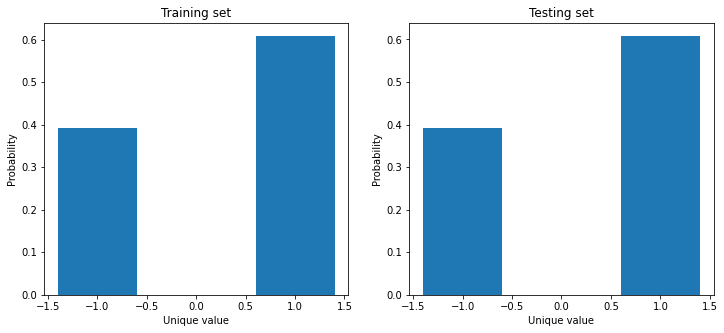

In [14]:
def value_counts(y):
    vals, cnts = np.unique(y, return_counts=True)
    probs = cnts / np.sum(cnts)
    for value, count, prob in zip(vals, cnts, probs):
        print(f"  {value} appears {count} times - {prob*100:.2f}%")
    return vals, cnts, probs

print('Train labels:')
train_vals, train_cnts, train_probs = value_counts(y_train)
print('Test labels:')
test_vals, test_cnts, test_probs = value_counts(y_test)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
    
ax1.bar(train_vals, train_probs)
ax1.set_title("Training set")
ax1.set_xlabel("Unique value")
ax1.set_ylabel("Probability")

ax2.bar(test_vals, test_probs)
ax2.set_title("Testing set")
ax2.set_xlabel("Unique value")
ax2.set_ylabel("Probability")

plt.show()

# Metrics

In [15]:
# Calculate accuracy
def accuracy(y_pred, y_true):
    return np.sum(y_true == y_pred) / len(y_true)

# Calculate precision
def precision(y_pred, y_true):
    class_labels = np.unique(y_true)  # Get unique class labels
    precision_scores = []
    for label in class_labels:
        TP = np.sum(np.logical_and(y_pred == label, y_true == label))
        FP = np.sum(np.logical_and(y_pred == label, y_true != label))
        precision = TP / (TP + FP)
        precision_scores.append(precision)
    average_precision = np.mean(precision_scores)
    return average_precision

# Calculate recall
def recall(y_pred, y_true):
    class_labels = np.unique(y_true)  # Get unique class labels
    recall_scores = []
    for label in class_labels:
        TP = np.sum(np.logical_and(y_pred == label, y_true == label))
        FN = np.sum(np.logical_and(y_pred != label, y_true == label))
        recall = TP / (TP + FN)
        recall_scores.append(recall)
    average_recall = np.mean(recall_scores)
    return average_recall

# Calculate F1 score
def f1(y_pred, y_true):
    class_labels = np.unique(y_true)  # Get unique class labels
    f1_scores = []
    for label in class_labels:
        TP = np.sum(np.logical_and(y_pred == label, y_true == label))
        FP = np.sum(np.logical_and(y_pred == label, y_true != label))
        FN = np.sum(np.logical_and(y_pred != label, y_true == label))
        precision = TP / (TP + FP)
        recall = TP / (TP + FN)
        f1 = 2 * (precision * recall) / (precision + recall)
        f1_scores.append(f1)
    average_f1 = np.mean(f1_scores)
    return average_f1

# Confusion matrix
def confusion_matrix():
    pass

# Models

## Decision Tree

In [16]:
# Decision tree node class
class DTNode:
    N_THRESHOLD = 4 # don't split if node has fewer examples than this
    H_THRESHOLD = .01 # don't split if node has entropy less than this
    H_REDUCTION_THRESHOLD = .001 # don't split if entropy reduction is less than this
    index = 0

    def __init__(self, data=None, config=None):
        self.config = config
        if config != None:
            self.N_THRESHOLD = config[0]
            self.H_THRESHOLD = config[1]
            self.H_REDUCTION_THRESHOLD = config[2]
        
        DTNode.index += 1
        self.index = DTNode.index # node has unique number
        self.data = data
        self.prob = None
        if data is not None:
            self.n = float(data.shape[0]) # number of examples
            self.indices = range(data.shape[1] - 1) # feature indices
            self.set_h()

        self.splits = {}

        self.feat_id = None # feature index
        self.thres = None # threshold
        self.lchild = None # left child
        self.rchild = None # right child
        self.parent = None

    # Create split on feature 'i' at value 'th'
    def split(self, i, th):
        self.feat_id = i
        self.thres = th
        self.lchild = DTNode(self.data[self.data[:, i] < th], self.config)
        self.rchild = DTNode(self.data[self.data[:, i] >= th], self.config)
        self.splits[i].remove(th)

    # Evaluate candidate split by weighted average entropy
    def split_eval(self, i, th):
        lc = DTNode(self.data[self.data[:, i] < th], self.config)
        rc = DTNode(self.data[self.data[:, i] >= th], self.config)
        pl = lc.n / self.n
        pr = 1.0 - pl
        avgH = pl * lc.H + pr * rc.H
        return avgH, lc, rc
    
    # Entropy of class labels in this node, assumes 1, -1
    def set_h(self):
        b = .001
        npos = np.sum(self.data[:,-1] == 1) # count labels 1
        p = (npos + b) / (self.n + b + b)
        self.prob = p
        self.H = -p * np.log(p) - (1-p) * np.log(1-p)

    def build_tree(self):
        if self.H < self.H_THRESHOLD or self.n <= self.N_THRESHOLD:
            return
        # Find the best split
        (i, th, (h, lc, rc)) = argmax([(i, th, self.split_eval(i, th)) \
                                            for i in self.indices \
                                            for th in self.get_splits(i)],
                                        lambda x : -x[2][0]) # x = (a, b, (h, c, d))
        
        if (self.H - h) < self.H_REDUCTION_THRESHOLD:
            return
        # Recurse
        self.feat_id = i
        self.thres = th
        self.lchild = lc
        self.rchild = rc
        self.lchild.parent = self
        self.rchild.parent = self
        self.lchild.build_tree()
        self.rchild.build_tree()
    
    # Sort examples and return middle points between every two consecutive sampes
    def get_splits(self, i):
        if i not in self.splits:
            d = np.sort(np.unique(self.data[:,i]), axis=None)
            d1 = d[:-1]
            d2 = d[1:]
            self.splits[i] = (d1 + d2) / 2.0
        return self.splits[i]

    # Classify a data point
    def classify(self, x):
        if self.feat_id == None: # leaf node
            return self.prob
        elif x[self.feat_id] < self.thres:
            return self.lchild.classify(x) # go to left child
        else:
            return self.rchild.classify(x) # go to right child
        
    def display(self, depth=0, max_depth=3):
        if depth > max_depth:
            print(depth*'  ', 'Depth >', max_depth)
        if self.feat_id is None:
            print(depth*'  ', '=>', '%.2f'%self.prob, '[ n=', self.n, ']')
            return
        print(depth*'  ', 'Ft.', self.feat_id, '<', self.thres, '[ n=', self.n, ']')
        self.lchild.display(depth+1, max_depth)
        self.rchild.display(depth+1, max_depth)

def argmax(l, f):
    """
    Return the element in list l that gives highest value on f

    @param l: C{List} of items
    @param f: C{Procedure} that maps an item into a numeric score
    @returns: the element of C{l} that has the highest score
    """
    vals = [f(x) for x in l]
    return l[vals.index(max(vals))]

In [17]:
class DecisionTree:
    def fit(self, X, Y, config=None):
        D = np.hstack([X,Y])
        self.root = DTNode(D, config)
        self.root.build_tree()
    def predict(self, X):
        pred = np.array([np.apply_along_axis(self.root.classify, 1, X)]).T - 0.5
        pred[pred >= 0] = 1
        pred[pred < 0] = -1
        return pred
    def display(self, depth=0, max_depth=3):
        self.root.display(depth, max_depth)

## Bagging

In [18]:
class Bagging:
    def __init__(self, num_trees=5):
        self.ntrees = num_trees
        self.trees = []
    def fit(self, X, Y, config=None):
        for i in range(self.ntrees):
            # perms = np.random.permutation(len(X))
            idxs = np.random.choice(len(X), size=len(X), replace=True)
            X_train = X[idxs, :]
            Y_train = Y[idxs, :]
            dt = DecisionTree()
            dt.fit(X_train, Y_train, config)
            self.trees.append(dt)
    def predict(self, X):
        preds = []
        if len(self.trees) == 0: return None
        for dt in self.trees:
            pred = dt.predict(X)
            preds.append(pred)
        preds = np.hstack(preds)
        return np.sign(preds.mean(axis=1, keepdims=True))

## Random Forest

In [19]:
class RandomForest:
    def __init__(self, num_trees=5, num_features=None):
        self.ntrees = num_trees
        self.nfeats = num_features
        self.trees = []
        self.feats = []
    
    def fit(self, X, Y, config=None):
        for i in range(self.ntrees):
            idxs = np.random.choice(len(X), size=len(X), replace=True)
            if self.nfeats is not None:
                features = np.random.choice(X.shape[1], size=self.nfeats, replace=False)
                X_train = X[idxs][:, features]
                self.feats.append(features)
            else:
                X_train = X[idxs]
            Y_train = Y[idxs]
            dt = DecisionTree()
            dt.fit(X_train, Y_train, config)
            self.trees.append(dt)
    
    def predict(self, X):
        preds = []
        if len(self.trees) == 0:
            return None
        for i in range(len(self.trees)):
            dt = self.trees[i]
            if self.nfeats is not None:
                features = self.feats[i]
                X_test = X[:, features]
            else:
                X_test = X
                
            pred = dt.predict(X_test)
            preds.append(pred)
        preds = np.hstack(preds)
        return np.sign(np.mean(preds, axis=1, keepdims=True))

In [20]:
def evaluate(model_class, X_train, Y_train, X_test, Y_test, max_depth=5, verbose=True, config=None, args=None):
    if args:
        model = model_class(*args)
    else:
        model = model_class()
    model.fit(X_train, Y_train, config)
    pred_test = model.predict(X_test)
    acc_s = accuracy(pred_test, Y_test)
    prec_s = precision(pred_test, Y_test)
    rec_s = recall(pred_test, Y_test)
    f1_s = f1(pred_test, Y_test)
    if verbose:
        print(f'  Accuracy  : {acc_s:.5f}')
        print(f'  Precision : {prec_s:.5f}')
        print(f'  Recall    : {rec_s:.5f}')
        print(f'  F1        : {f1_s:.5f}')
        if isinstance(model, DecisionTree): 
            model.display(max_depth=max_depth)
    return acc_s, prec_s, rec_s, f1_s

In [64]:
def cross_validate(data, labels, k=10, model='DecisionTree', verbose=True, config=None, args=None):
    if model == 'Bagging':
        model_class = Bagging
    elif model == 'RandomForest':
        model_class = RandomForest
    else:
        model_class = DecisionTree
    indices = np.random.permutation(data.shape[0])
    X = data[indices,:]
    Y = labels[indices,:]
    s_data = np.array_split(X, k, axis=0)
    s_labels = np.array_split(Y, k, axis=0)
    acc_s = 0.
    prec_s = 0.
    rec_s = 0.
    f1_s = 0.
    for i in range(k):
        X_train = np.concatenate(s_data[:i] + s_data[i+1:], axis=0)
        Y_train = np.concatenate(s_labels[:i] + s_labels[i+1:], axis=0)
        X_test = np.array(s_data[i])
        Y_test = np.array(s_labels[i])
        if verbose == "first_tree":
            if i == 0:
                acc, prec, rec, f1 = evaluate(model_class, X_train, Y_train, X_test, Y_test, verbose=True, config=config, args=args)
            else:
                acc, prec, rec, f1 = evaluate(model_class, X_train, Y_train, X_test, Y_test, verbose=False, config=config, args=args)
        elif verbose == True:
            print('Round',i+1)
            acc, prec, rec, f1 = evaluate(model_class, X_train, Y_train, X_test, Y_test, verbose=True, config=config, args=args)
        else:
            acc, prec, rec, f1 = evaluate(model_class, X_train, Y_train, X_test, Y_test, verbose=False, config=config, args=args)
        acc_s += acc
        prec_s += prec
        rec_s += rec
        f1_s += f1
    print('\nCROSS VALIDATION RESULTS:')
    print(f'- Avg. Accuracy  : {acc_s/k:.5f}')
    print(f'- Avg. Precision : {prec_s/k:.5f}')
    print(f'- Avg. Recall    : {rec_s/k:.5f}')
    print(f'- Avg. F1        : {f1_s/k:.5f}')
    return acc_s/k, prec_s/k, rec_s/k, f1_s/k


# cross_validate(X_train, y_train, model='RandomForest', k=5, verbose=True, args=[5, 150])
cross_validate(X_train, y_train, model='Bagging', k=5, verbose=True, args=[7])


Round: 1
  Accuracy  : 0.90706
  Precision : 0.91229
  Recall    : 0.89006
  F1        : 0.89890
Round: 2
  Accuracy  : 0.88985
  Precision : 0.89261
  Recall    : 0.87962
  F1        : 0.88468
Round: 3
  Accuracy  : 0.91738
  Precision : 0.91262
  Recall    : 0.90485
  F1        : 0.90850
Round: 4
  Accuracy  : 0.89845
  Precision : 0.90238
  Recall    : 0.88980
  F1        : 0.89453
Round: 5
  Accuracy  : 0.89329
  Precision : 0.89528
  Recall    : 0.87891
  F1        : 0.88556
CROSS VALIDATION RESULTS:
- Accuracy  : 0.90120
- Precision : 0.90303
- Recall    : 0.88865
- F1        : 0.89443


(0.9012048192771085, 0.903033484095722, 0.8886483345696078, 0.8944344881789963)

# Fine tuning

In [ ]:
'''
TODO (Viet)
1. Find the best values 
    of N_THRESHOLD, H_THRESHOLD, H_REDUCTION_THRESHOLD for Decision tree
2. Find the best values
    of 'num_trees' and 'num_features' for Random forest
3. Find the best values
    of 'num_trees' for Bagging
'''

In [ ]:
'''
TODO
- Function to turn user inputs into vector ready to be put into 'predit' function (shape (1, 238)) (Lam)
- Plot various values of hyperparams for dtree, bagging, rforest -> find optimal values & Confusion matrix (Loc)
- Fix errors for functions to save and load models (by yaml) (Dai)
'''

# Evaluation

**Warnings:** Don't run this part until very end

In [2]:
evaluate(RandomForest, X_train, y_train, X_test, y_test, args=[5, 150])

# Inference

In [21]:
rf_clf = RandomForest(num_trees=5, num_features=150)
rf_clf.fit(X_train, y_train)

# save model

In [22]:
id = 123

# load model

print('(Graduated: 1.0, Dropout: -1.0)')
print('- Prediction :', rf_clf.predict(X_test[id,:].reshape(1,-1))[0][0])
print('- Actual     :', y_test[id][0])

(Enrolled: 1.0, Dropout: -1.0)
- Prediction : -1.0
- Actual     : -1.0


# Save model

In [ ]:
# TODO